In [141]:
import os
import torch
import numpy as np
from tqdm import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from pytorch3d.transforms import matrix_to_axis_angle, axis_angle_to_matrix
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    BlendParams,
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    AmbientLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    PerspectiveCameras
)
# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)

In [197]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts = verts.unsqueeze(0).to(device)
faces = faces.unsqueeze(0).to(device)
verts_rgb = torch.ones_like(verts, device=device)
textures = TexturesVertex(verts_features=verts_rgb)

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
meshes = Meshes(verts=verts, faces=faces, textures=textures)

/root/anaconda3/envs/optimizer/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [198]:
faces.shape

torch.Size([1, 2464, 3])

In [207]:
################################
### Create a reference image ###
################################
# Select the viewpoint using spherical angles
distance = 3  # distance from camera to the object
elevation = 50.0  # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
# Initialize an OpenGL perspective camera.
cameras = PerspectiveCameras(device=device, image_size=((256,256),), R=R, T=T, in_ndc=False)

raster_settings = RasterizationSettings(
            image_size=(256, 256),
            blur_radius=0.0,
            faces_per_pixel=1,
            bin_size = None,
            max_faces_per_bin = None
        )

lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

renderer_rgb = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

rasterizer_depth = MeshRasterizer(
cameras=cameras,
raster_settings=raster_settings
)


In [225]:
depth_ref = rasterizer_depth(meshes)
depth_ref = depth_ref.zbuf
print(depth_ref)
depth_ref[depth_ref<0] = 10

# NEW added to generate depth image
depth_ref = depth_ref.cpu().numpy()

tensor([[[[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],

         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],

         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],

         ...,

         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],

         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],

         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]]]], device='cuda:0')


In [218]:
def sixd2matrot(pose_6d):
    '''
    :param pose_6d: Nx6
    :return: pose_matrot: Nx3x3
    '''
    rot_vec_1 = pose_6d[:,:3]
    rot_vec_2 = pose_6d[:,3:6]
    rot_vec_3 = torch.cross(rot_vec_1, rot_vec_2)
    pose_matrot = torch.stack([rot_vec_1,rot_vec_2,rot_vec_3],dim=-1)
    return pose_matrot

In [219]:
def matrot2sixd(pose_matrot):
    '''
    :param pose_matrot: Nx3x3
    :return: pose_6d: Nx6
    '''
    pose_6d = torch.cat([pose_matrot[:,:3,0], pose_matrot[:,:3,1]], dim=1)
    return pose_6d

In [220]:
class Model(nn.Module):
    # def __init__(self, meshes, renderer, image_ref):
    def __init__(self, meshes, renderer, depth_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Get the silhouette of the reference RGB image by finding all the non zero values.
        # image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
        # self.register_buffer('image_ref', image_ref)

        # NEW added to get depth image
        depth_ref = torch.from_numpy((depth_ref).astype(np.float32))
        self.register_buffer('depth_ref', depth_ref)

        # Create an optimizable parameter for the x, y, z position of the camera.
        # self.camera_position = torch.from_numpy(np.array([0.0114, 2.3306, 3.0206], dtype=np.float32)).to(meshes.device)
            # Original starting point
            # torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))
            # Set to a starting point closer to the reference depth image

        self.camera_position = torch.from_numpy(np.array([0.0114, 2.3306, 3.0206], dtype=np.float32)).to(meshes.device)


        obj_rot = torch.FloatTensor(np.eye(3)).unsqueeze(0)
        # obj_rot = matrix_to_axis_angle(obj_rot) #[1, 3]
        obj_rot = matrot2sixd(obj_rot) #[1, 6]

        obj_trans = torch.zeros((1, 3))
        self.obj_rot = nn.Parameter(obj_rot.to(self.device))
        self.obj_trans = nn.Parameter(obj_trans.to(self.device))

        self.camera_position.requires_grad = False
        self.obj_rot.requires_grad = True
        self.obj_trans.requires_grad = True

        self.verts, faces_idx, _ = load_obj("./teapot.obj")
        self.faces = faces_idx.verts_idx

        # Initialize each vertex to be white in color.
        self.verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
        # textures = Textures(verts_rgb=verts_rgb.to(device))
        self.textures = TexturesVertex(verts_features=verts_rgb.to(device))

        self.h = torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).to(self.device)

    def apply_transform(self, obj_pose, obj_trans,obj_verts):
        # obj_rot = axis_angle_to_matrix(obj_pose[:, :3]).squeeze()
        # obj_trans = obj_pose[:, 3:].T
        # obj_pose = torch.cat((obj_rot, obj_trans), -1)
        # obj_mat = torch.cat([obj_pose, self.h], dim=0)
        rot_mat = sixd2matrot(obj_pose) #[1, 3, 3]
        obj_mat = torch.cat([rot_mat, obj_trans.unsqueeze(-1)], dim=-1) #[1, 3, 4]
        obj_mat = torch.cat([obj_mat, self.h.unsqueeze(1)], dim=1) #[1, 4, 4]
        obj_mat = obj_mat[0]

        # Append 1 to each coordinate to convert them to homogeneous coordinates
        h = torch.ones((obj_verts.shape[0], 1), device=self.device)
        homogeneous_points = torch.cat((obj_verts, h), 1)
        # Apply matrix multiplication
        transformed_points = homogeneous_points @ obj_mat.T #[N, 4] [4, 4]
        # Convert back to Cartesian coordinates
        transformed_points_cartesian = transformed_points[:, :3] / transformed_points[:, 3:]

        return transformed_points_cartesian
    
    # def apply_transform(self, obj_pose, obj_verts):
    #     obj_rot = axis_angle_to_matrix(obj_pose[:, :3]).squeeze()
    #     obj_trans = obj_pose[:, 3:].T
    #     obj_pose = torch.cat((obj_rot, obj_trans), -1)
    #     obj_mat = torch.cat([obj_pose, self.h], dim=0)
    #     # rot_mat = sixd2matrot(obj_pose) #[1, 3, 3]
    #     # obj_mat = torch.cat([rot_mat, obj_trans.unsqueeze(-1)], dim=-1) #[1, 3, 4]
    #     # obj_mat = torch.cat([obj_mat, self.h.unsqueeze(1)], dim=1) #[1, 4, 4]
    #     # obj_mat = obj_mat[0]

    #     # Append 1 to each coordinate to convert them to homogeneous coordinates
    #     h = torch.ones((obj_verts.shape[0], 1), device=self.device)
    #     homogeneous_points = torch.cat((obj_verts, h), 1)
    #     # Apply matrix multiplication
    #     transformed_points = homogeneous_points @ obj_mat.T #[N, 4] [4, 4]
    #     # Convert back to Cartesian coordinates
    #     transformed_points_cartesian = transformed_points[:, :3] / transformed_points[:, 3:]

    #     return transformed_points_cartesian


    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        # obj_pose = torch.cat((self.obj_rot, self.obj_trans), -1)

        init_vert = self.verts.clone().to(device)
        # verts = self.apply_transform(obj_pose, init_vert)
        verts = self.apply_transform(self.obj_rot, self.obj_trans, init_vert)
        teapot_mesh = Meshes(
            verts=[verts.to(device)],
            faces=[self.faces.to(device)],
            textures=self.textures
        )

        image = self.renderer(meshes_world=teapot_mesh, R=R, T=T)
        # NEW added to generate depth image
        image = image.zbuf
        image[image < 0] = 10

        # Calculate the silhouette loss
        # loss = torch.sum((image[..., 3] - self.image_ref) ** 2)

        # NEW Calculate the depth image loss
        loss = torch.sum((image - self.depth_ref) ** 2)

        return loss, image

In [221]:
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

In [222]:
model = Model(meshes=meshes, renderer=rasterizer_depth, depth_ref=depth_ref).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/root/anaconda3/envs/optimizer/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


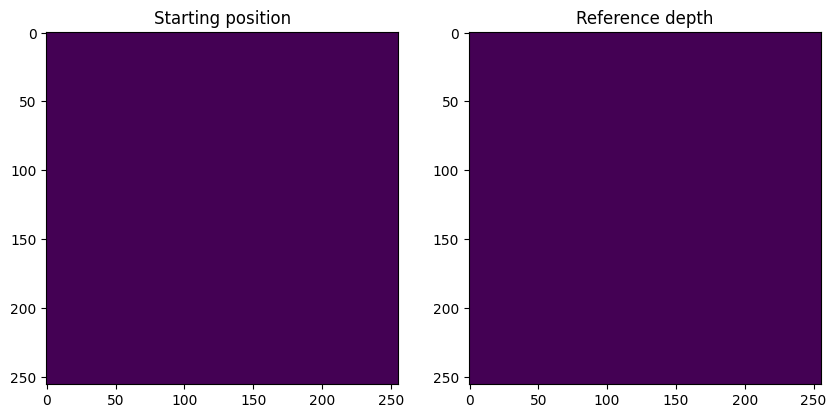

In [223]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
# plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.imshow(image_init.detach().squeeze().cpu().numpy())  # NEW for plotting depth image
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.depth_ref.cpu().numpy().squeeze())
plt.grid(False)
# plt.title("Reference silhouette")
plt.title("Reference depth")  # NEW for plotting depth image
plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]


KeyboardInterrupt: 

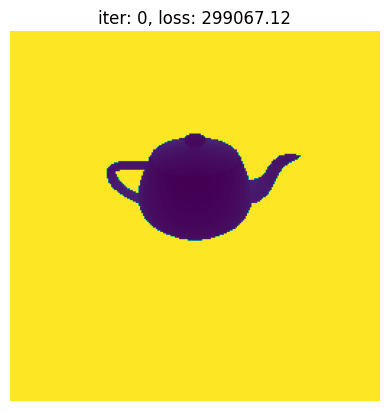

In [151]:
plt.figure()
for i in tqdm(range(1500)):
    optimizer.zero_grad()
    loss, depth_current = model()
    loss.backward()
    optimizer.step()

    # loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 200:
        break

    # Save outputs to create a GIF.
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        # plt.imshow(image[..., :3])
        plt.imshow(depth_current.detach().squeeze().cpu().numpy())
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
        # plt.show()
        plt.pause(0.01)

writer.close()

In [227]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

In [229]:
d_path = "/home/workplace/HOnnotate_OXR/dataset/230905/230905_S01_obj_30_grasp_01/trial_0/depth_crop/mas/mas_0021.png"
m_path = "/home/workplace/HOnnotate_OXR/dataset/230905/230905_S01_obj_30_grasp_01/trial_0/segmentation_deep/mas/raw_seg_results/mas_0021.png"
depth = np.asarray(cv2.imread(d_path, cv2.IMREAD_UNCHANGED)).astype(float)
seg = np.asarray(cv2.imread(m_path, cv2.IMREAD_UNCHANGED)).astype(float)

In [ ]:
depth_obj = np.where(seg != 1, 10, depth)

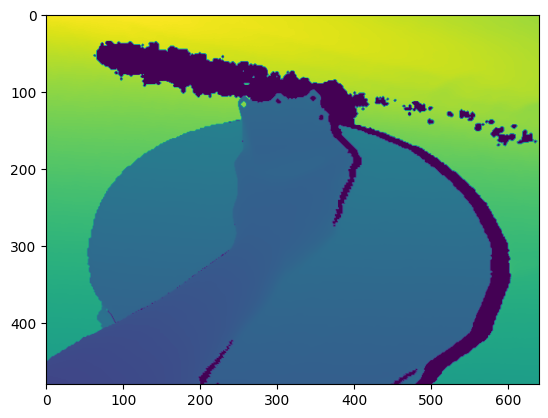

In [230]:
plt.imshow(depth)

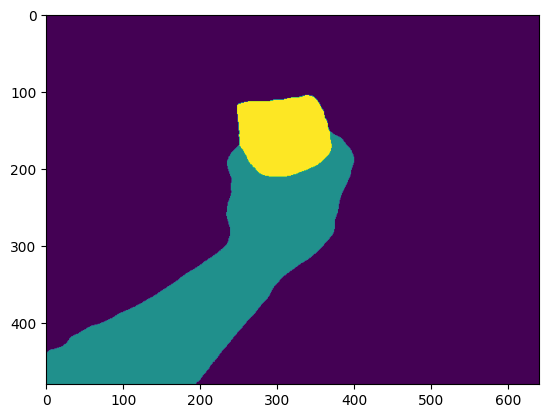

In [231]:
plt.imshow(seg)